# Credit card transaction data Classification

A solution to classify credit card transaction data as authentic or fraudulent. Dataset is taken from Kaggle. The data is the result of a PCA transformation applied on original data due to confidentiality issues. The features are the principle components obtained as result of the transformation. 

#### Perform needed imports

In [81]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
import xgboost as xgb

#### Set configuration values

In [82]:
RANDOM_STATE = 2021
TEST_SIZE = 0.2 # test dataset size = 20% 
EVAL_SIZE = 0.2 # evaluation dataset size = 20% 

RFC_ESTIMATORS = 50 # number of trees in the forest
RFC_N_JOBS = -1 # number of jobs to run in parallel, -1: use all processors

XGB_STEPS = 1000 # number of boosting iterations
VERBOSE_EVAL = 50 # rounds at which validation verbose is printed
EARLY_STOP = 100 # min rounds for early stopping to activate

pd.set_option('display.max_columns', 40)
%matplotlib inline

#### Reading and exploring the data

In [83]:

transaction_data = pd.read_csv('transaction_data.csv')

print('\nhead: \n', transaction_data.head())
print('\ntail: \n', transaction_data.tail())
print('\ndescription: \n', transaction_data.describe())
print('\ncolumns: \n', transaction_data.columns)
print('\ninfo: \n')
transaction_data.info()


head: 
    Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
1  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772   
2  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293 -0.165946   
3  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757 -0.287924   
4 -0.270533  0.817739  0.753074 -0.822843  0.538196  1.345852 -1.119670   

        V15       V16       V17       V18       V19  

All values are of type float except values of column 'Class'

Values in feature columns, V1 to V28 which are PCA values, have low standard deviation, where as values in column 'Amount' have high standard deviation.

Max value of 172792 in column 'Time' confirms the data is taken across a perioid of 2 days, 172792 seconds ~ 2 days.

#### Remove duplicate entries

In [84]:
rows_before = transaction_data.shape[0]
transaction_data.drop_duplicates(inplace=True)
rows_after = transaction_data.shape[0]
print(f'dropped {rows_before-rows_after} duplicate rows')

dropped 1081 duplicate rows


#### Find amount of missing values

In [85]:
print('missing values per column:\n')
print(transaction_data.isnull().sum())
total_data = np.product(transaction_data.shape)
print('\nPercentage of total data missing: ', transaction_data.isnull().sum().sum()/total_data*100, '%')


missing values per column:

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Percentage of total data missing:  0.0 %


The dataset doesn't have any missing values

#### Check for class imbalance

Class 0 indicates authentic transaction and Class 1 indicated a fradulent transaction.

0    283253
1       473
Name: Class, dtype: int64


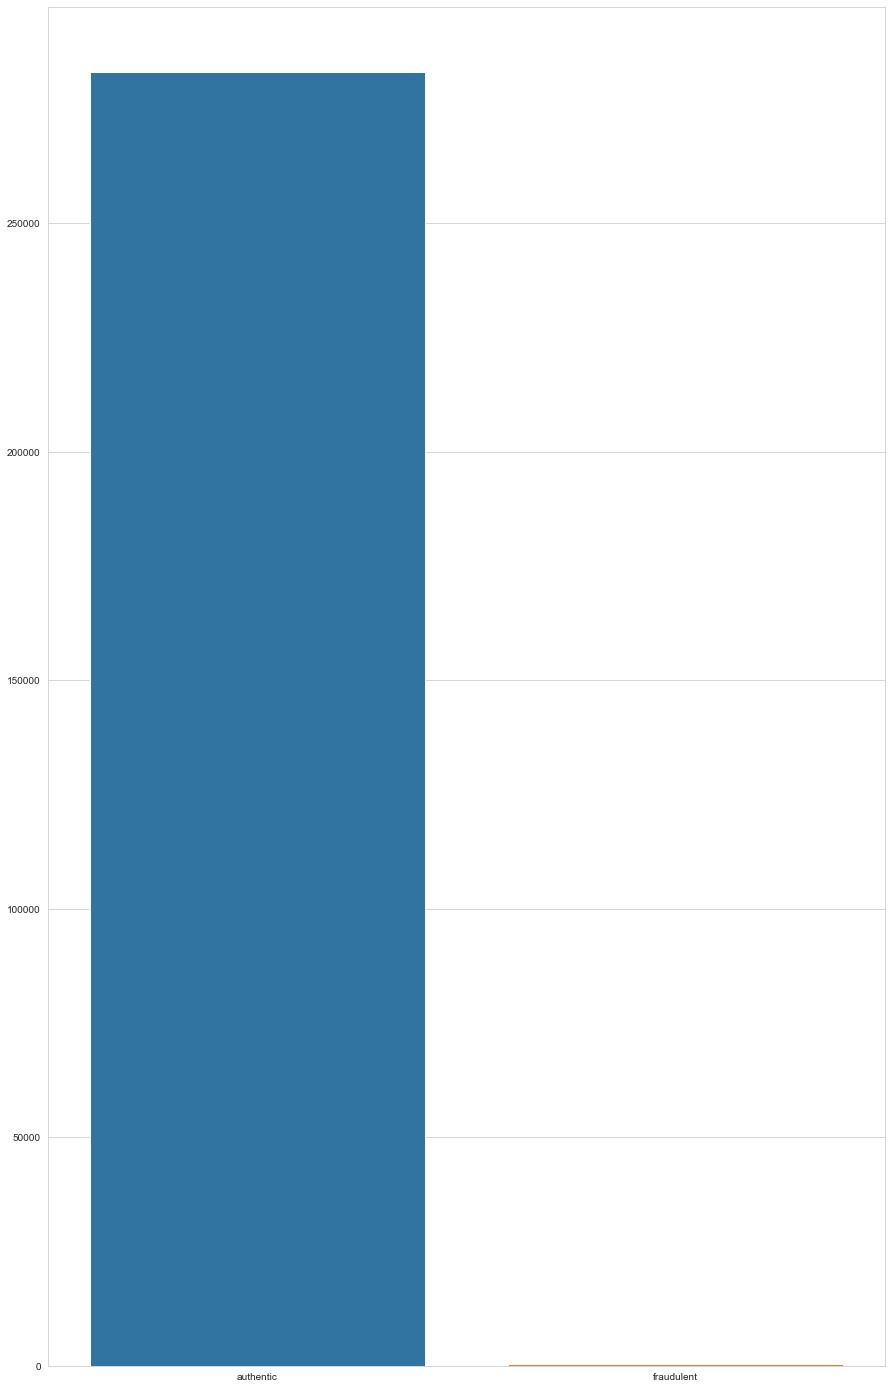

In [86]:
class_vc_srs = transaction_data['Class'].value_counts()
print(class_vc_srs)
plt.figure(figsize=(15, 25))
sns.barplot(x=[{0:'authentic', 1:'fraudulent'}[x] for x in class_vc_srs.index], y = class_vc_srs.values)

From the data 99% of transactions are authentic while 0.166% of transactions are fraudulent.

#### Scale values

Before scaling


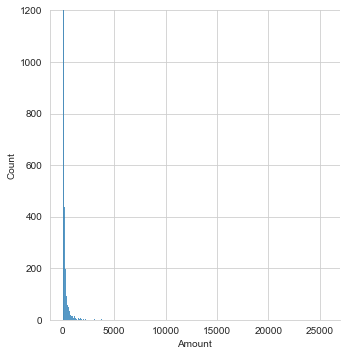

After scaling


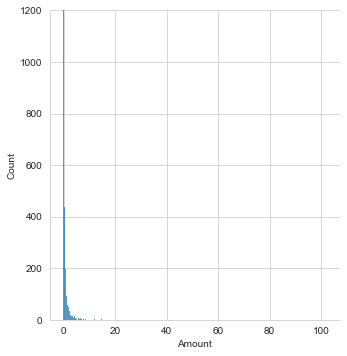

count    2.837260e+05
mean    -5.409347e-17
std      1.000002e+00
min     -3.533268e-01
25%     -3.309625e-01
50%     -2.654671e-01
75%     -4.378088e-02
max      1.022476e+02
Name: Amount, dtype: float64

In [87]:
print('Before scaling')
ax = sns.displot(data=transaction_data["Amount"])
ax.set(ylim=(0, 1200))
plt.show()

scaler = StandardScaler()
transaction_data['Amount'] = scaler.fit_transform(transaction_data['Amount'].values.reshape(-1,1))

print('After scaling')
ax = sns.displot(data=transaction_data["Amount"])
ax.set(ylim=(0, 1200))
plt.show()

transaction_data['Amount'].describe()

Values in column 'Amount' has been scaled have a standard deviation of nearly 1.

#### Find correlation between feature columns

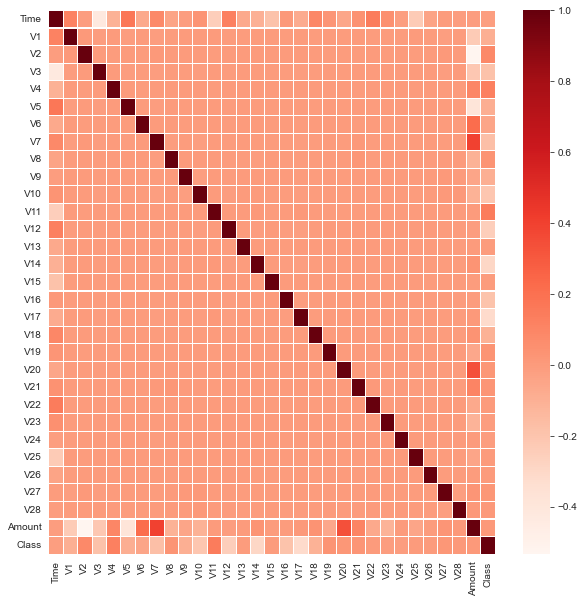

In [88]:
feature_corr = transaction_data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(data=feature_corr, xticklabels=feature_corr.columns, yticklabels=feature_corr.columns
            , linewidths=0.1, cmap='Reds')
plt.show()

Features such as V7 and V20 have strong positive correlation with feature 'Amount' where as V2, V5 have negetive correlation with 'Amount'.
Features V3 and v11 have negative correlation with Time column

#### Feature densities of both classes

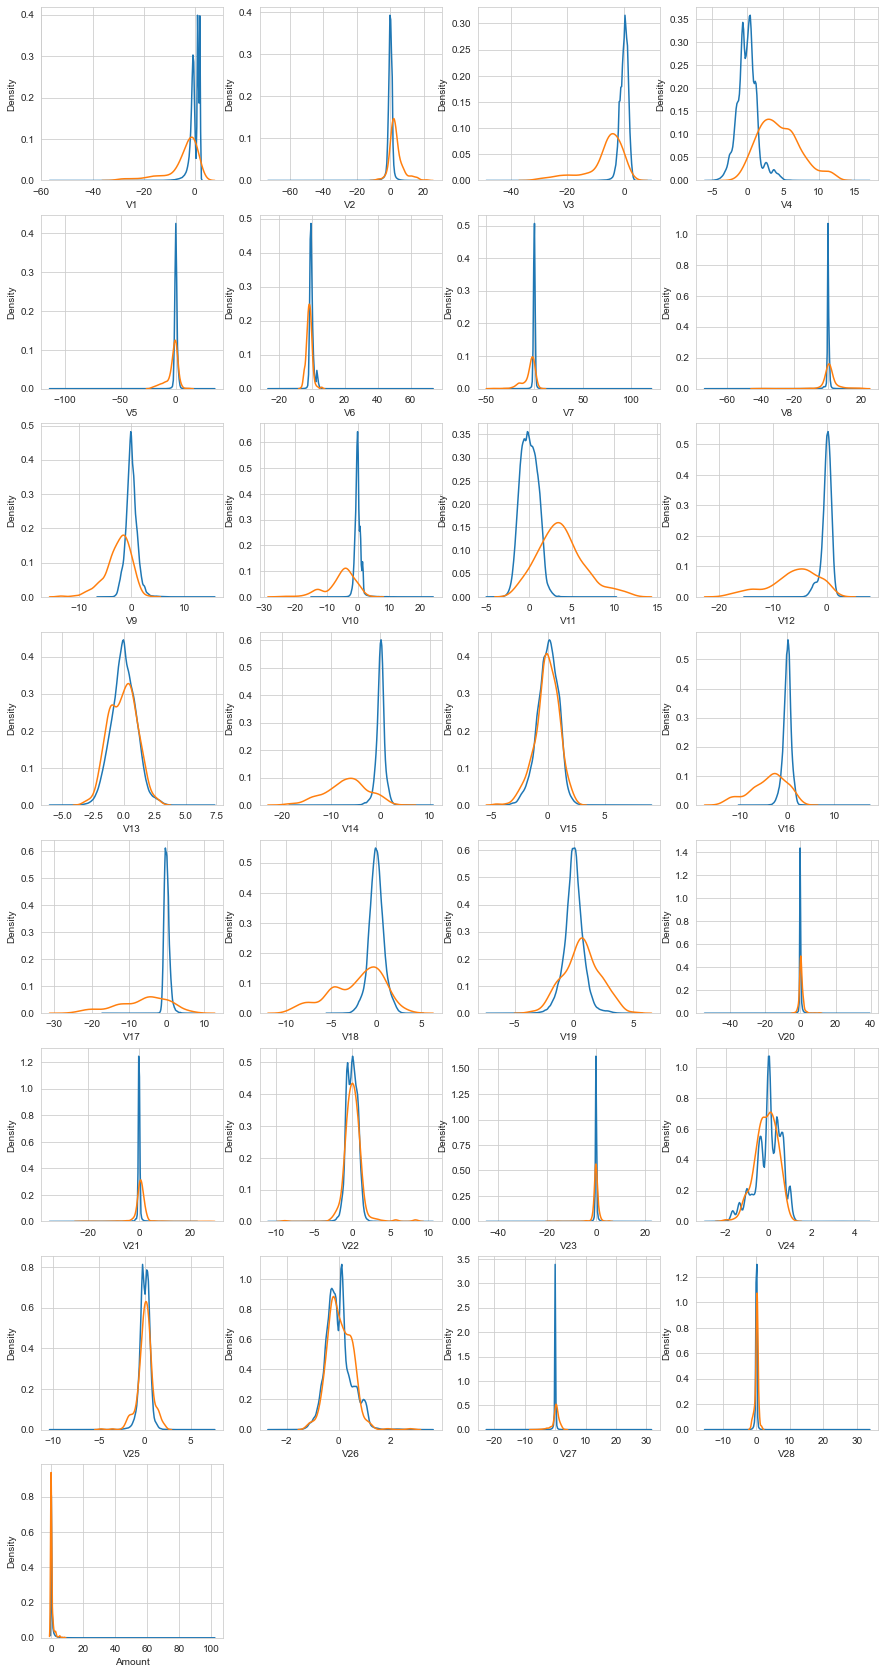

In [89]:
fraud_trans = transaction_data.loc[transaction_data['Class']==1]
authentic_trans = transaction_data.loc[transaction_data['Class']==0]

sns.set_style('whitegrid')
fig, ax = plt.subplots(5, 6, figsize=(15, 30))
for i, feat in enumerate(features):
    plt.subplot(8,4,i+1)
    sns.kdeplot(data=authentic_trans[feat], label='auth')
    sns.kdeplot(data=fraud_trans[feat], label='fraud')
    plt.xlabel(feat)

plt.show()

From the density plots it is observed that features V4, V11 and V14 have more distributed values across each class.

#### Prepare data for training

In [90]:
train_df, test_df = train_test_split(transaction_data, test_size=TEST_SIZE, shuffle=True, random_state=RANDOM_STATE)
train_df, eval_df = train_test_split(train_df, test_size=EVAL_SIZE, shuffle=True, random_state=RANDOM_STATE)

features = transaction_data.columns.values.tolist()
features.remove('Class')
features.remove('Time')
target = 'Class'

#### Random Forest Classifier

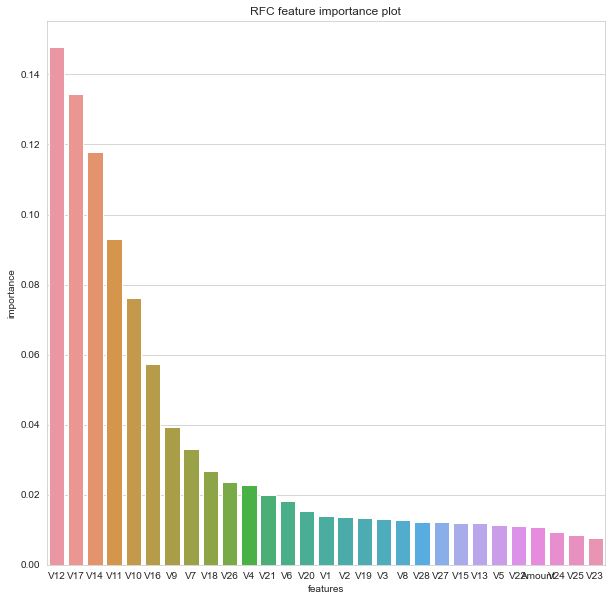

confusion_matrix: 
 [[56641    10]
 [   17    78]]

accuracy score:  0.9995241955380115

classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.89      0.82      0.85        95

    accuracy                           1.00     56746
   macro avg       0.94      0.91      0.93     56746
weighted avg       1.00      1.00      1.00     56746


RFC roc_auc_score:  0.9104380560941461


In [91]:
my_rfc = RandomForestClassifier(n_estimators=RFC_ESTIMATORS,
                                n_jobs=RFC_N_JOBS,
                                random_state=RANDOM_STATE)
my_rfc.fit(train_df[features], train_df[target].values)

preds = my_rfc.predict(test_df[features])

fimp_df = pd.DataFrame({'features': features, 'importance': my_rfc.feature_importances_}).sort_values(by='importance',
                                                                                                      ascending=False)
plt.figure(figsize=(10, 10))
plt.title('RFC feature importance plot')
sns.barplot(x='features', y='importance', data=fimp_df)
plt.show()

print('confusion_matrix: \n', confusion_matrix(test_df[target], preds))
print('\naccuracy score: ', accuracy_score(test_df[target], preds))
print('\nclassification report: \n', classification_report(test_df[target], preds))
print('\nRFC roc_auc_score: ', roc_auc_score(test_df[target].values, preds))


#### XG-Boost Classifier

[0]	train-auc:0.87612	eval-auc:0.83723
[50]	train-auc:0.92183	eval-auc:0.90334
[100]	train-auc:0.93289	eval-auc:0.90839
[150]	train-auc:0.97467	eval-auc:0.96437
[200]	train-auc:0.98670	eval-auc:0.96965
[250]	train-auc:0.99163	eval-auc:0.97340
[300]	train-auc:0.99426	eval-auc:0.97279
[331]	train-auc:0.99549	eval-auc:0.97066


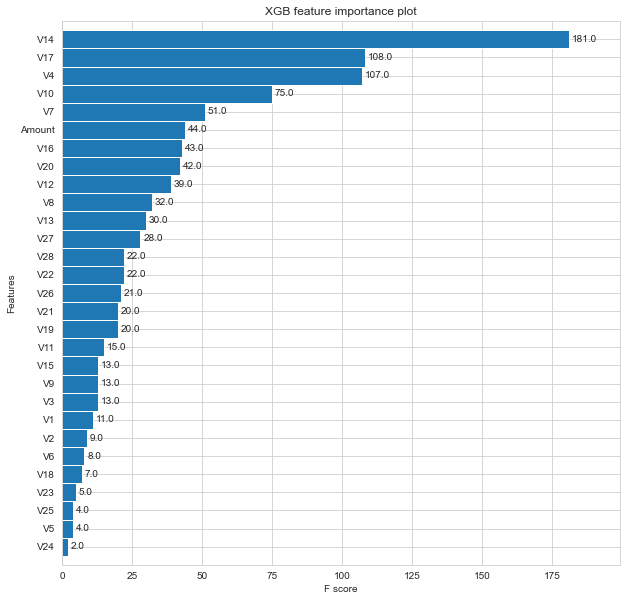


confusion_matrix: 
 [[56642     9]
 [   18    77]]

accuracy score:  0.9995241955380115

classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.90      0.81      0.85        95

    accuracy                           1.00     56746
   macro avg       0.95      0.91      0.93     56746
weighted avg       1.00      1.00      1.00     56746


XGB roc_auc_score:  0.9879321125004529


In [92]:
#XGBOOST
dm_train = xgb.DMatrix(train_df[features], train_df[target].values)
dm_eval = xgb.DMatrix(eval_df[features], eval_df[target].values)
dm_test = xgb.DMatrix(test_df[features], test_df[target].values)

validation_sets = [(dm_train, 'train'), (dm_eval, 'eval')]

params = {
    'eta': 0.035,
    'max_depth': 2,
    'objective': 'binary:logistic',
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'eval_metric': 'auc',
    'random_state': RANDOM_STATE
}

my_xgb = xgb.train(params,
                   dm_train,
                   XGB_STEPS,
                   validation_sets,
                   early_stopping_rounds=EARLY_STOP,
                   maximize=True,
                   verbose_eval=VERBOSE_EVAL)

fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
xgb.plot_importance(my_xgb, height=1, title='XGB feature importance plot', ax=ax)
plt.show()

preds = my_xgb.predict(dm_test)
bin_preds = [round(val) for val in preds]

print('\nconfusion_matrix: \n', confusion_matrix(test_df[target], bin_preds))
print('\naccuracy score: ', accuracy_score(test_df[target], bin_preds))
print('\nclassification report: \n', classification_report(test_df[target], bin_preds))
print('\nXGB roc_auc_score: ', roc_auc_score(test_df[target], preds))


#### Observations and  conclusion

Both RFC and XGB-classifier has an accuracy score of 99.9% but this could be because of the highly imbalanced data.

From the classification reports it is observed that both models have similar precision and recall and therefore similar f1-score for both classes.

Using Area under the cure of Reciever Operator Characteristic curve, which is a good evalution metric for binary classification models, it is observed that the XGB model has a higher score compared to the RFC model.

Thus a conclusion can be drawn that for this classificatioin problem the XG-Boost model performs better at classifying fraudulent transactions. 